In [1]:
%load_ext autoreload
%autoreload 2

In [40]:
from zero_churn_model.imports import * # basic imports
from zero_churn_model import helpers as hp

from scipy.stats import pearsonr 
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import t 
from copy import deepcopy as copy
from tqdm import tqdm
from scipy.stats import chi2_contingency

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [3]:
BASE_DATA = hp.load_data('interim', 'interim-data.parquet')
print(BASE_DATA.shape)
BASE_DATA.head(5)

(50000, 13470)


,churn,var1,var2,var3,var4,var5,var6,var7,var8,var9,...,var14983,var14984,var14989,var14990,var14993,var14995,var14996,var14997,var14998,var14999
0,0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,...,0,-1,0,0.05912,0.00070,0,0,0.98282,0.83532,-1
1,0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,...,0,-1,0,0.16062,0.00126,0,0,0.98282,0.83532,-1
2,0,0.0,0.0,0.0,0.0,1,0,0.0,0.0,0.0,...,0,0,0,0.04442,0.00146,0,0,0.98282,0.83532,-1
3,0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,...,-1,0,0,0.09664,0.00038,0,0,0.98282,0.83532,-1
4,1,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,...,-1,0,0,0.05912,0.01496,1,-1,0.98282,0.83532,-1


In [4]:
df = BASE_DATA.reset_index(drop=True).copy()

# Analyze Continuous Columns

First, let's create two lists, `cols_categorical` and `cols_continuous`. 

Noting that all of our columns are numeric types:

In [5]:
# all columns are numerical
x = df.dtypes
x[~(x == 'float64') & ~(x == 'int64')]

Series([], dtype: object)

...therefore we'll choose which ones to treat as categorical by identifying how many different values are present:

In [6]:
cols_continuous = []
cols_categorical = []
for col in [x for x in df.columns if x != 'churn']:
    if df[col].unique().shape[0] > 10:
        cols_continuous.append(col)
    else:
        cols_categorical.append(col)
        
nc = len(cols_continuous)
nt = len(cols_categorical)
print(f"there are {nc} continuous columns and {nt} categorical columns")

there are 5305 continuous columns and 8164 categorical columns


In [7]:
msg = 'All columns should be either categorical or continous. '
assert len(cols_continuous) + len(cols_categorical) == df.shape[1]-1, msg

Previously, we set missing values to -1:

In [8]:
n = (df[cols_continuous] == -1).sum().sum()
print(f"there are {n} values of -1 in the continous columns")

there are 3024 values of -1 in the continous columns


Let's just interpolate these values with the mean of each column:

In [9]:
for col in cols_continuous:
    df[col] = df[col].replace(-1, df[col].mean())

In [10]:
n = (df[cols_continuous] == -1).sum().sum()
print(f"there are {n} values of -1 in the continous columns")

there are 0 values of -1 in the continous columns


## Subset Columns with Mann-Whitney Distribution Test

These data have a very large number of possible features. It isn't likely that all of them are useful to the prediction task, so let's do some work to reduce the dimensionality of the data. 

This is a binary classification task (i.e. we're predicting `churn`, which takes on values 0 or 1). For any given potential feature, said feature isn't likely very useful for prediction if the distribution is the same between the two groups; i.e. if possible feature `x` has the same distribution for both `churn = 1` and `churn = 0`, then `x` isn't likely a useful feature. 

We'll use a nonparametric test to evaluate whether or not the distributions differ across values of `churn` - the Mann-Whitney U test. 

We've included a function which applies the U test:

In [11]:
hp.display_source(hp.mw_test)

```python
def mw_test(df, col, p_threshold=0.05):
    """Perform a Mann-Whitney U test to compare two groups in a DataFrame.

    Parameters
    ----------
    df : pandas.DataFrame
        The DataFrame containing the data to test.
    col : str
        The column name on which to perform the test.
    p_threshold : float, optional
        The p-value threshold to reject the null hypothesis (default is
        0.05).

    Returns
    -------
    str
        'different' if the null hypothesis is rejected, otherwise
        'same'.
    """
    a = df.loc[df['churn'] == 0, col]
    b = df.loc[df['churn'] == 1, col]
    stat, p = mwtest(a, b, alternative='two-sided')
    # if p < threshold, the null hypothesis can be rejected 
    if p < p_threshold:
        return 'different'
    else:
        return 'same'

```

In [12]:
%%time
cols_continuous_utest = []
for col in cols_continuous:
    if hp.mw_test(df, col) == 'different':
        cols_continuous_utest.append(col)
p = len(cols_continuous_utest) / len(cols_continuous)
print(f"{100*p:.1f}% of continuous columns passed the U test. ")

35.6% of continuous columns passed the U test. 
CPU times: user 16.4 s, sys: 0 ns, total: 16.4 s
Wall time: 16.4 s


In [13]:
len(cols_continuous_utest)

1890

## Analyze for Feature Correlations

Next, we'll want to analyze for candidate features that are correlated to each other. Since we have 1800+ columns and 50K rows, we will have to do this on a sample of the dataframe and calculate the t-test p values manually.

In [14]:
fn = 'correlation-matrix-elastic-impact-abf65b50.csv'
fp = hp.data_path('interim', fn, validate=False)

In [15]:
%%time
corr = df[cols_continuous_utest].corr()
corr.to_csv(fp)

CPU times: user 5min 3s, sys: 257 ms, total: 5min 3s
Wall time: 5min 3s


In [16]:
# reload archived data
corr = hp.load_data('interim', fn).set_index('Unnamed: 0')

Now that we have our correlation matrix, let's create a heatmap:

<Axes: ylabel='Unnamed: 0'>

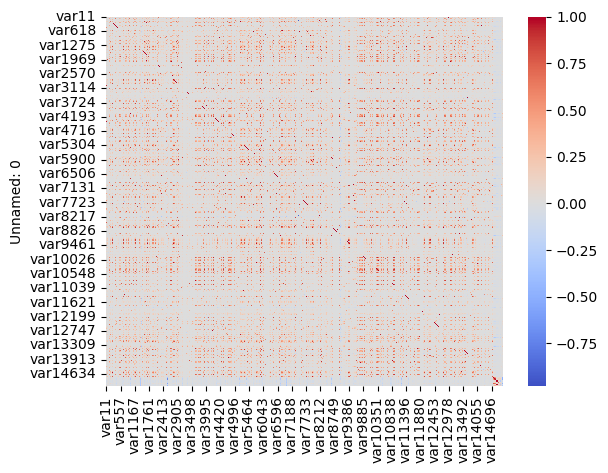

In [17]:
sns.heatmap(corr, center=0, cmap='coolwarm')

It looks like potentially many of our features are correlated. Let's use PCA to pare down these variables.

## PCA Transformation 

Below we'll use PCA to transform the data into a new set of uncorrelated components.

In [21]:
%%time
scaler = StandardScaler()
data = scaler.fit_transform(df[cols_continuous_utest])

pca = PCA(n_components=0.95)
pca.fit(data)
data = pca.transform(data)
assert data.shape[1] == pca.n_components_

CPU times: user 1min 22s, sys: 10 s, total: 1min 32s
Wall time: 13.6 s


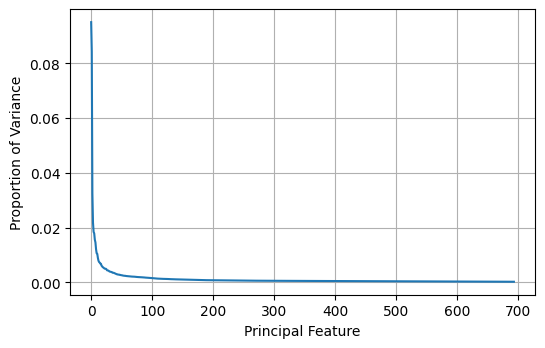

In [22]:
w = 6
fig, ax = plt.subplots(figsize=(w, w/1.618))
ax.plot(pca.explained_variance_ratio_)
ax.set_xlabel('Principal Feature')
ax.set_ylabel('Proportion of Variance');
ax.grid()

In [23]:
fp = hp.data_path('interim', 'correlation-matrix-scary-cut-cd34d065.csv', validate=False)
corr_pca = pd.DataFrame(data).corr()
corr_pca.to_csv(fp)

In [24]:
# load saved correlation matrix and plot
corr_pca = pd.read_csv(fp).set_index('Unnamed: 0')

<Axes: ylabel='Unnamed: 0'>

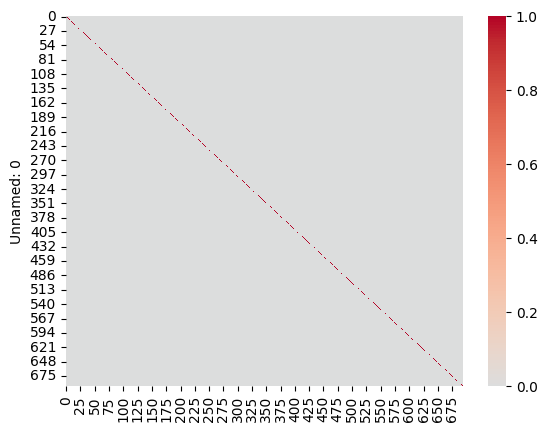

In [25]:
sns.heatmap(corr_pca, center=0, cmap='coolwarm')

Now we have an array of uncorrelated variables that we can use later for modeling. Let's save this for later. 

In [26]:
# archive principal components
fn = 'continuous-pc-data-690-dysfunctional-consideration-706fac20.parquet'
fp = hp.data_path('processed', fn, validate=False)
d = pd.DataFrame(data)
d.to_parquet(fp)

# Categorical Variables 

Now that we've explored and handle the continuous columns, let's study the categorical variables.

In [27]:
df = BASE_DATA.copy()

In [28]:
print(f"there are {len(cols_categorical)} categorical columns. ")
df[cols_categorical].head(10)

there are 8164 categorical columns. 


,var1,var2,var5,var6,var8,var9,var10,var12,var13,var14,...,var14973,var14975,var14980,var14981,var14983,var14984,var14989,var14995,var14996,var14999
0,0.0,0.0,0,0,0.0,0.0,0,0.0,0.0,0,...,-1,0,-1,-1,0,-1,0,0,0,-1
1,0.0,0.0,0,0,0.0,0.0,0,0.0,0.0,0,...,-1,-1,0,-1,0,-1,0,0,0,-1
2,0.0,0.0,1,0,0.0,0.0,0,0.0,0.0,0,...,-1,-1,-1,-1,0,0,0,0,0,-1
3,0.0,0.0,0,0,0.0,0.0,0,0.0,0.0,0,...,-1,-1,-1,-1,-1,0,0,0,0,-1
4,0.0,0.0,0,0,0.0,0.0,0,0.0,0.0,0,...,-1,-1,-1,-1,-1,0,0,1,-1,-1
5,0.0,0.0,0,0,0.0,0.0,0,0.0,0.0,0,...,-1,-1,-1,-1,-1,0,0,0,0,-1
6,0.0,0.0,0,0,0.0,0.0,0,0.0,0.0,0,...,-1,0,-1,-1,-1,-1,0,1,0,-1
7,0.0,0.0,0,0,0.0,0.0,0,0.0,0.0,0,...,-1,-1,-1,-1,0,0,0,1,0,-1
8,0.0,0.0,0,0,0.0,0.0,0,0.0,0.0,0,...,-1,-1,-1,-1,-1,0,0,1,1,-1
9,0.0,0.0,0,0,0.0,0.0,0,0.0,0.0,0,...,-1,-1,-1,-1,-1,0,0,1,0,-1


Inspect how many distinct categories are present in each categorical column:

In [29]:
category_counts = dict()
for col in cols_categorical:
    category_counts[col] = df[col].unique().shape[0]
un = pd.DataFrame.from_dict(category_counts, orient='index').rename(columns={0:'n_unique'})
un.head(3)

,n_unique
var1,4
var2,3
var5,2


In [30]:
un['n_unique'].describe()

count    8164.000000
mean        3.108648
std         2.142213
min         1.000000
25%         2.000000
50%         2.000000
75%         3.000000
max        10.000000
Name: n_unique, dtype: float64

## Encoding

Just to make this a neater dataset, let's label encode the values:

In [31]:
from sklearn.preprocessing import LabelEncoder

In [32]:
%%time
le = LabelEncoder()
for col in cols_categorical:
    df[col] = le.fit_transform(df[col])

CPU times: user 16.3 s, sys: 320 ms, total: 16.6 s
Wall time: 16.6 s


In [33]:
df.head(10)

,churn,var1,var2,var3,var4,var5,var6,var7,var8,var9,...,var14983,var14984,var14989,var14990,var14993,var14995,var14996,var14997,var14998,var14999
0,0,0,0,0.0,0.0,0,0,0.0,0,0,...,1,0,1,0.05912,0.00070,1,1,0.98282,0.83532,0
1,0,0,0,0.0,0.0,0,0,0.0,0,0,...,1,0,1,0.16062,0.00126,1,1,0.98282,0.83532,0
2,0,0,0,0.0,0.0,1,0,0.0,0,0,...,1,1,1,0.04442,0.00146,1,1,0.98282,0.83532,0
3,0,0,0,0.0,0.0,0,0,0.0,0,0,...,0,1,1,0.09664,0.00038,1,1,0.98282,0.83532,0
4,1,0,0,0.0,0.0,0,0,0.0,0,0,...,0,1,1,0.05912,0.01496,2,0,0.98282,0.83532,0
5,0,0,0,0.0,0.0,0,0,0.0,0,0,...,0,1,1,0.08352,0.00030,1,1,0.98282,0.83532,0
6,0,0,0,0.0,0.0,0,0,0.0,0,0,...,0,0,1,0.09664,0.00090,2,1,0.98282,0.83532,0
7,0,0,0,0.0,0.0,0,0,0.0,0,0,...,1,1,1,0.04210,0.08882,2,1,0.98282,0.83532,0
8,1,0,0,0.0,0.0,0,0,0.0,0,0,...,0,1,1,0.05912,0.02300,2,2,0.98282,0.83532,0
9,0,0,0,0.0,0.0,0,0,0.0,0,0,...,0,1,1,0.02728,0.01552,2,1,0.98282,0.83532,0


## Value Counts

What is the distribution of values across categories for each of these potential features?

Some of these features are very weighted toward one category:

In [34]:
col = 'var14368'
x = df[col].value_counts()
x

var14368
0    49928
1       72
Name: count, dtype: int64

Odds are that categories like this won't be very useful to our analysis, i.e. it isn't likely that there is a lot of useful information embedded in something that only happens 72 out of ~50k instances). 

Let's analyze further:

In [35]:
n_largest_category = []
for col in cols_categorical:
    x = df[col].value_counts()
    n_largest_category.append({'col':col, 'n':x.max()})

ncats = pd.DataFrame(n_largest_category).sort_values(by=['n']).reset_index(drop=True)
ncats['p'] = ncats['n'] / len(df)

Now we can plot the data:

Text(0, 0.5, 'Percent in Largest Category')

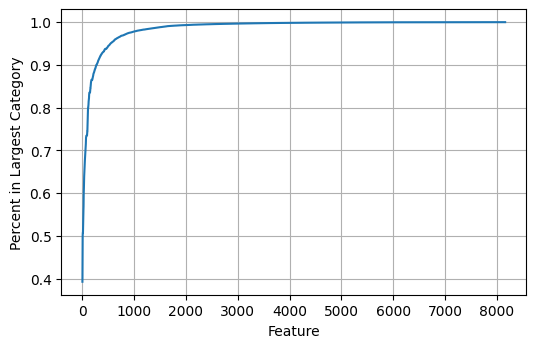

In [36]:
w = 6
fig, ax = plt.subplots(figsize=(w, w/1.618))

ax.plot(ncats['p'])
ax.grid()
ax.set_xlabel('Feature')
ax.set_ylabel('Percent in Largest Category')

The above graph shows that a very large number of these features are extremely sparse, i.e. they are mostly of one value. 

Let's proceed by excluding variables that are more than 98% contained in one of the categories.

In [37]:
m = ncats['p'] < 0.98
ncats[m].shape

(1064, 3)

That gives us just over 1,000 variables, which seems like a good starting point.

In [38]:
cols_categorical_balanced = ncats.loc[m, 'col'].tolist()

## Chi-Square Statistical Test

Now we have `cols_categorical_balanced` which contains labels of categorical columns that are somewhat balanced across categories (i.e. less than 98% of rows are in one category). 

But which of these are even potentially useful to our analysis? 

We'll apply a Chi-Square test to each of the remaining predictor columns.

This test is applied to a matrix such as this one:

In [39]:
col = 'var10283'
y = df['churn']
x = df[col]

d = pd.crosstab(y, x)
d

var10283,0,1
churn,,
0,43823,2505
1,3550,122


...where each cell represents the number of occurences of both variables being their given value, e.g. in the above case there are 122 cases where `churn` is 1 and the variable is also 1. The null hypothesis is that the predictor (variable) and outcome are independent. 

In [41]:
cols_categorical_balanced_chisq = []
y = df['churn']
p_thresh = 0.05

for col in cols_categorical_balanced:
    x = df[col]
    ct = pd.crosstab(y, x)
    _, p, _, _ = chi2_contingency(ct)
    if p < p_thresh:
        cols_categorical_balanced_chisq.append(col)
print(f"{len(cols_categorical_balanced_chisq)} out of {len(cols_categorical_balanced)} columns passed the Chi-Squared test. ")

579 out of 1064 columns passed the Chi-Squared test. 


...this reduces our columns even further, from 1064 to 579. 

In [42]:
df[cols_categorical_balanced_chisq]

,var5945,var13871,var13172,var6636,var14846,var5826,var14995,var8034,var14885,var14821,...,var11405,var4459,var1824,var6430,var3027,var13997,var6712,var3978,var2282,var11478
0,7,6,0,2,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,4,0,2,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,2,1,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
3,2,2,0,2,2,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
4,3,3,1,2,3,1,2,1,1,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0,4,0,0,3,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
49996,0,0,3,3,0,3,2,1,0,0,...,0,0,0,0,0,0,0,0,0,0
49997,3,3,1,2,0,1,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
49998,3,3,0,2,3,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0


## OneHot Encoding 

Create `X_cat` that is the result of expanding the columns of `df`, for our columns that passed the Chi-Squared test.

In [43]:
from sklearn.preprocessing import OneHotEncoder

In [44]:
encoder = OneHotEncoder(sparse_output=False)
X_cat = encoder.fit_transform(df[cols_categorical_balanced_chisq])

In [45]:
print(X_cat.shape)
X_cat

(50000, 1761)


array([[0., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 1., 0.]])

# Collect Modeling Data

Now, we will put this all together into a single dataframe intended to be used for model training.

In [46]:
# load the PCA data created earlier in this notebook
fn = 'continuous-pc-data-690-dysfunctional-consideration-706fac20.parquet'
X_cont = hp.load_data('processed', fn).values

In [47]:
print(X_cont.shape)
X_cont

(50000, 694)


array([[  0.94963783,   7.839033  ,  -3.32583068, ...,  -0.15091131,
          0.06946457,  -0.11522062],
       [ -5.75938282,  15.96619626,  -3.49180322, ...,   0.03029363,
         -0.59659717,   1.11794695],
       [ -2.33890594,  -6.58930163,  -0.67139223, ...,  -1.52347191,
          0.50833306,  -0.12479788],
       ...,
       [ -4.71033252,  -2.85726868,  10.2714598 , ...,  -0.12531212,
         -0.61377974,  -0.08295831],
       [ -1.20697448,  -3.29096004,   8.11286874, ...,  -0.28051375,
         -0.40770533,  -0.23235171],
       [ -4.69313344,  -9.99210148, -14.99875785, ...,   0.64381512,
          1.02462238,  -0.46497406]])

In [48]:
X = np.concatenate((X_cont, X_cat), axis=1)
assert X.shape[1] == X_cont.shape[1] + X_cat.shape[1]
assert len(X) == len(df)
print(X.shape)
X

(50000, 2455)


array([[  0.94963783,   7.839033  ,  -3.32583068, ...,   0.        ,
          1.        ,   0.        ],
       [ -5.75938282,  15.96619626,  -3.49180322, ...,   0.        ,
          1.        ,   0.        ],
       [ -2.33890594,  -6.58930163,  -0.67139223, ...,   0.        ,
          1.        ,   0.        ],
       ...,
       [ -4.71033252,  -2.85726868,  10.2714598 , ...,   0.        ,
          1.        ,   0.        ],
       [ -1.20697448,  -3.29096004,   8.11286874, ...,   0.        ,
          1.        ,   0.        ],
       [ -4.69313344,  -9.99210148, -14.99875785, ...,   0.        ,
          1.        ,   0.        ]])

In [49]:
xd = pd.DataFrame(X)
xd['y'] = df['churn']
xd = xd[['y'] + [x for x in xd.columns if x != 'y']].copy()
xd.columns = [str(i) for i in xd.columns]
xd

,y,0,1,2,3,4,5,6,7,8,...,2445,2446,2447,2448,2449,2450,2451,2452,2453,2454
0,0,0.949638,7.839033,-3.325831,1.166039,0.898431,-3.722978,-3.724379,-2.138678,1.649482,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,0,-5.759383,15.966196,-3.491803,-1.913483,2.193621,-2.567054,-8.970534,5.853391,-0.845518,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,0,-2.338906,-6.589302,-0.671392,9.972804,-2.382445,5.158881,-0.942877,-0.157386,0.065975,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,0,5.883239,-10.595399,-7.679696,1.201918,-0.242519,1.327820,0.764475,-2.752347,0.683654,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,1,-3.259075,-4.480679,5.016750,-5.977697,0.735466,-6.407818,3.702090,-1.342238,0.404511,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0,-3.025844,-3.352949,9.703043,-7.586021,2.366780,6.320173,-1.299374,-2.469102,0.864478,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
49996,0,1.996179,-5.737697,0.725675,7.744634,1.057948,1.348730,1.702760,0.865531,-0.868099,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
49997,0,-4.710333,-2.857269,10.271460,6.936067,-1.820282,-2.467885,2.660451,-0.657090,0.261541,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
49998,0,-1.206974,-3.290960,8.112869,2.362655,-1.177492,-4.249821,3.447623,-0.374345,-0.995541,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [50]:
fn = 'model-data-pca-chi2-obsolete-fold-f28f32e6.parquet'
fp = hp.data_path('processed', fn, validate=False)
xd.to_parquet(fp)